# advent of code

https://adventofcode.com/settings

(login with github)

running with lewagon envtry finding cookie by going to developer tools > storage

to download input via request need cookies!

try finding cookie by going to developer tools > storage

session:"53616c7465645f5f0d9c485692603b4bf39627d657a461b73296c03ea325a9d793cf86d14e1e4c575ad96e8f53ebf8965a3fa1b9b44a87cb4102ed29f5b64e0c"

apparently they are stored in sqlite file in Profile folder (/home/svetlana/snap/firefox/common/.mozilla/firefox/1p0df6c0.default/)

In [3]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### day 1

Task sum of two-digit numbers in each line which are first and last digit 

If only one digit, then double it (99 for the first)

Ideally I would use np.vectorize on extraction function and an array of type object

In [4]:
# 1
with open('input_01', 'r') as f:
    #print(f.readlines()) #this will keep \n
    mylist = f.read().splitlines() # no \n

In [24]:
%time
# brute force (list of lists, nested for loop = bad!)
def get_sum_day1(list_of_strings):
    num_list = []
    for line in list_of_strings:
        num=[d for d in line if d.isdigit()]
        num_list.append(int(num[0]+num[-1]))
    return num_list

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 17.4 µs


In [25]:
np.sum(get_sum_day1(mylist))

53921

Now we need to also get spelled out numbers like two, three, ...

There is python lib num2words (it even has ordinals) but by simply Ctrl F I conclude that my input only has one to nine.

In [26]:
# now need for dictionary replacement
word2num = {
     'one':'1'
    ,'two':'2'
    ,'three':'3'
    ,'four':'4'
    ,'five':'5'
    ,'six':'6'
    ,'seven':'7'
    ,'eight':'8'
    ,'nine':'9'
}

In [30]:
#mylist[0].translate(word2num)
# brute force 2
mylist2 = [d.replace(word,num) for word, num in word2num.items() for d in mylist]


In [32]:
np.sum(get_sum_day1(mylist2)) #485079 is too high though...

485079

check https://www.reddit.com/r/adventofcode/ for hints:

apparently the words can overlap! 'twone' should give 21....

In [72]:
import re
matches = re.finditer('(?=two)|(?=one)','twone')
for match in matches:
    print( match)

<re.Match object; span=(0, 0), match=''>
<re.Match object; span=(2, 2), match=''>


### day 2

Determine which games would have been possible if the bag had been loaded with only 12 red cubes, 13 green cubes, and 14 blue cubes. What is the sum of the IDs of those games?



In [2]:
with open('input_02', 'r') as f:
    str_list = f.read().splitlines()

In [3]:
str_list[0]

'Game 1: 4 red, 8 green; 8 green, 6 red; 13 red, 8 green; 2 blue, 4 red, 4 green'

In [21]:
# store ids which are valid
game_ids = []

# store constraints
constraints = {'red':12, 'green':13, 'blue':14}

def check_draw(draw, constraints=constraints):
    """
    take draw as string and optional constraint dict
    check against constraint if draw is valid or not
    return bool
    """
    # make a dict color:number for the draw
    draw_dic = {col.split()[1]:int(col.split()[0]) for col in draw.split(', ')}
    # compare to constraint
    valid = all([draw_dic[k] <= constraints[k] for k in draw_dic.keys()])
    return valid

# loop over games
for game_str in str_list:
    id, game = game_str.split(': ')
    #convert id to int
    id = int(id.strip('Game '))
    #split game inot draws
    draws = game.split('; ')
    # store game id only if all draws are valid
    if all([check_draw(draw) for draw in draws]):
        game_ids.append(id)

In [24]:
np.sum(game_ids) #answer

3099

### day 4

each card has winning numbers | numbers you have

for matching each winning number you get 2^n points with n=0 for first etc.

In [1]:
with open('input_04','r') as f:
    cards = f.read().splitlines()

In [17]:
# list of powers of 2 which each card will be worth (minus 1 since 2^0=1)
powers = []
for card in cards:
    winning_num=card.split(': ')[1].split(' | ')[0].split()
    my_num=card.split(': ')[1].split(' | ')[1].split()
    power = len([num for num in my_num if num in winning_num])
    if power > 0:
        powers.append(power)

In [25]:
np.sum(2**((np.array(powers)-1))) #answer

24542

### day 6

boat races: you charge for specific amount of time and it allows you to travel with different speeds

1ms charging adds 1mm/ms speed

task: for each race, how many ways to beat current record are there? then multiply for answer.

In [36]:
Time=[58,     81,     96,     76]
Distance=[434,   1041,   2219,   1218]

In [37]:
# we just need a formula and plot it
# speed = charge_time
# time_to_travel = Time-charge_time
# distance_traveled = time_to_travel*speed = time_to_travel*charge_time=(Time-charge_time)*charge_time = Time*charge_time - charge_time**2

num_of_ways = []

for Time, Distance in zip(Time, Distance):
    distance_traveled = []
    # for all times to charge from 0 to max time
    for i in range(Time):
        distance_traveled.append((Time-i)*i)
    num_of_ways.append(np.sum(np.array(distance_traveled)>Distance))

In [40]:
np.prod(np.array(num_of_ways)) #answer

1159152

### day 7

need to rank card hands byspecific rules then multiply their bid by rank


In [4]:
cards = pd.read_csv('input_07', sep=' ', header=None)
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
# create rules for ranking

#len(set(list('AAAAA'))) # always remember: nunique() of a list is a set!

# this is like a custom sorting rule
# need: 1) custom sort (see chatGPT for assigning weights to cards)
# need: 2) classifier wrapping this up
# first order by class, within class by card weight

##### function to sort into class ######

from collections import Counter

# classes - assign them a number already - we have 7
def classify_hand(hand: str):
    """
    This function will determine relative weights of hands
    """
    # how many unique types?
    #cardinality = len(set(list(hand)))
    counts = Counter(list(hand))

    # highest: rank 7 (all cards same)
    #if cardinality==1:
    if 5 in counts.values():
        rank = 7

    # if we have 2 kinds of cards:
        # if 4 are same (4 of a kind)
    elif 4 in counts.values(): #cardinality==2:
        rank = 6
        # if 3 are same (full house)
    elif all(val in counts.values() for val in (2,3)):
        rank = 5

    # if we have 3 kinds of cards:
        # if 3 are the same (3 of a kind)
    elif 3 in counts.values():
        rank = 4
        # if there are 2 pairs
    elif list(counts.values()).count(2)==2:
        rank = 3

    # if we have 4 kinds it is basically always 1 pair right?
    elif list(counts.values()).count(2)==1:
        rank = 2

    # if we have 5 kinds
    elif list(counts.values())==[1]*5:
        rank = 1
    return rank

In [8]:
####### function to sort by card weight #######

# this is our custom card sorter from GPT
# this only works for single-character strings :(

def custom_card_sort(card):
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    # Assign weights based on the order
    rule = {card: weight for weight, card in enumerate(order)}
    return rule.get(card)


# https://stackoverflow.com/questions/52475458/how-to-sort-pandas-dataframe-with-a-key
# do it vectorized instead!
# must take series and return series

def custom_card_sort_pd(series):
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    # Assign weights based on the order
    rule = {card: weight for weight, card in enumerate(order)}
    return series.apply(lambda x: rule.get(x)) # Return the weight for the card


In [26]:
# idea: convert cards into tuples mapping their value! then sort df by those (grouped by our group/class).
# we can actually sort tuples even of different length  :)
#sorted([(5,), (4,1), (3,2), (1,1,1,1,1), (2,3)])

def make_tuple(hand: str):
    """
    Converts a hand into a tuple of respective rank values
    """
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    rule = {card: weight+1 for weight, card in enumerate(order[::-1])}

    return tuple(rule.get(card) for card in list(hand))

In [38]:
# answer - multiply bid by rank and sum up
(cards
 .assign(class_ = lambda x : x[0].map(classify_hand)
             , rank_ = lambda x : x[0].map(make_tuple))
 .sort_values(by = ['class_', 'rank_'])
 .reset_index(drop=True)
 .assign(final_rank = lambda x : x.index +1,
         final_value = lambda x: x[1]*x['final_rank'])
)['final_value'].sum()

251927063

In [40]:
#sorted(cards.head(10)[0].tolist(), key=custom_card_sort) #TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'
#sorted(['bnf','zfg', 'aaa'])
# #!!! this key function should be vectorized
## 'It should expect a Series and return a Series with the same shape as the input.
# It will be applied to each column in by independently.'
# https://stackoverflow.com/questions/52475458/how-to-sort-pandas-dataframe-with-a-key
#cards.head(20).sort_values(by=0, key=custom_card_sort) # still not working maybe because there are 5th of cards

#### OOP

- use Think Python book and write class of card with methods from scratch
- "it is obvious what the attributes should be: rank and suit"
- "use integers to encode the ranks and suits"
- "we can override the behavior of the built-in operators by providing a method named `__cmp__`"

> __cmp__ takes two parameters, self and other, and returns a positive number if the first
object is greater, a negative number if the second object is greater, and 0 if they are equal to
each other.

The book proceeds to create classes for Deck and Hand but they hold a list of cards.

I guess for me the easier way at this point is to split the cards into the list or multiple series.


In [11]:
class Card(object):
    """ Represents a playing card
        To simplify, I remove suit since this is not a part of Camel Card.
    """
    def __init__(self, rank=0) -> None:
        self.rank = rank

    # provide rank as integer which is index of this list:
    rank_names = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']

    def __str__(self):
        """ returns a string of card's rank"""
        return rank_names[self.rank]

    def __lt__(self, other):
        ''' similar to cmp in py2 - compares rank'''
        return self.rank < other.rank

### day 12

So, condition records with no unknown spring conditions might look like this:


```
#.#.### 1,1,3
.#...#....###. 1,1,3
.#.###.#.###### 1,3,1,6
####.#...#... 4,1,1
#....######..#####. 1,6,5
.###.##....# 3,2,1
```

However, the condition records are partially damaged; some of the springs' conditions are actually unknown (?). For example:

```
???.### 1,1,3
.??..??...?##. 1,1,3
?#?#?#?#?#?#?#? 1,3,1,6
????.#...#... 4,1,1
????.######..#####. 1,6,5
?###???????? 3,2,1
```

In this example, the number of possible arrangements for each row is:

    ???.### 1,1,3 - 1 arrangement
    .??..??...?##. 1,1,3 - 4 arrangements
    ?#?#?#?#?#?#?#? 1,3,1,6 - 1 arrangement
    ????.#...#... 4,1,1 - 1 arrangement
    ????.######..#####. 1,6,5 - 4 arrangements
    ?###???????? 3,2,1 - 10 arrangements

Adding all of the possible arrangement counts together produces a total of 21 arrangements.

For each row, count all of the different arrangements of operational and broken springs that meet the given criteria. What is the sum of those counts?



In [44]:
inp = pd.read_csv('input_12', sep=' ', header = None)
inp.head()

,0,1
0,??????.??#.,"2,3"
1,??.?###?????????,"2,4,4"
2,?????????.??##?,"1,2,1,1,5"
3,?##?.????.?#?.?#?,"3,1,1,2,2"
4,?#?.#?##????,"3,1,4"


In [122]:
inp.dtypes

0    object
1    object
dtype: object

In [138]:
# convert string code field to tuple
inp['tuple'] = inp[1].map(lambda x : tuple(int(num) for num in x.split(',')))
inp.head(1)

,0,1,tuple
0,??????.??#.,"2,3","(2, 3)"


We need to:
1. split the code by ',' - this will give us groups of consequitive brokens (#)
2. *somehow* split the arrangement into corresponding groups 
3. combinatorics with possible combinaitons within those groups

In [61]:
def nonempty_split(arr:str):
    return [group for group in arr.split('.') if group] #without empty

In [57]:
# df.apply(lambda x : make_possible_combinations(x[0], x[1]))

#def make_possible_combinations(arr, code):
    #group_sizes = code.split(',')
    #n_groups = len(group_sizes)
    # make groups in actual string
    # imagine there were no '?'
    # groups = arr.split('.')
    # but see ex with 10!
    #if '.' in arr:
    #    groups = [group for group in arr.split('.') if group] #wihtout empty strings

    # another way would be to get boolean mask on '?'
    # and then treat this as masked string
    # handle if all False (no ?) = 1 combination

    # yet another way - try to mimic what my brain is doing
    # first identify existing groups of #/? and match them with code
    # then try to build up (if there are nearby ? and group too small, keep adding but combinatorially)
    # problem is sometimes ..?.. will match 1, exactly and sometimes ..#?. is exactly 2 and ???.. can match 1,1
    # so we need a clever pattern recognition strategy here
    # so first thing we know for sure is that \.+ matches , but only if # follows.. grrr
    # and ? can match both # and . .. OK ..
    # so we need a pseduo random brute force demasking + re.search with dynamic constraints ..
    # basically translate code into re.compile I guess

In [95]:
# imagine what fx was used to generate the code
# and then to randomly mask some parts
# and try to reverse those?
# in the worst case brute force all combinations randomly

def generate_code(arr):
    return tuple((len(broken) for broken in nonempty_split(arr)))


#def mask_string(arr):
    #

In [96]:
arr3 = '#...##.##....###'
code3 = generate_code(arr3)
code3


(1, 2, 2, 3)

In [87]:
import re
#re.compile()
# to put real curly braces you need to have double ones
# to put something inside them use triple!
# use code tuple to unpack list into format string regex


In [152]:
# now we need to inject chars according to our regex, hmm
# basically create all possible combinations of # and . inside given length and filter for match and count
# this could be quite brute forced already... we have 1000 rows


In [247]:
import itertools

##### function of arr(arrangement):str, code: tuple
def count_combinations(arr:str, code:tuple):
    """
    Brute force approach.
    It will generate a list of all possible arrangements from a given string
    , filter it by regex match given by the code in the tuple
    and return count of valid matching combinations.
    """
    # step1 (cheap) : brute force: generate all combinations
    combinations = [''.join(c) for c in itertools.product('#.', repeat = arr.count('?'))]
    # incorporate them instead of ? (f-string on iterable or smth)
    raw_strings = [arr.replace('?','{}').format(*combination) for combination in combinations]
    # step2: expensive - filter by re.match and count valid combinations
    # it should be + for internal # and * for the first/last .. sigh .. here goes my elegant regex
    pattern = re.compile('^\.*' + ''.join([f'#{{{i}}}\.+' for i in code[:-1]]) + f'#{{{code[-1]}}}\.*$')
    num_comb = len([c for c in raw_strings if pattern.match(c) is not None])
    return num_comb
    # step 3 - apply or map this onto df

In [244]:
# check funciton is not buggy on one row
count_combinations(inp[0][3], inp['tuple'][3])

24

In [ ]:
# try a min example
ex = pd.DataFrame({
    '0':
    ['???.###'
    ,'.??..??...?##.'
    ,'?#?#?#?#?#?#?#?'
    ,'????.#...#...'
    ,'????.######..#####.'
    ,'?###????????'],
    'tuple':
        [(1,1,3)
         ,(1,1,3)
         ,(1,3,1,6)
         ,(4,1,1)
         ,(1,6,5)
         ,(3,2,1)],
    'count':
        [1,4,1,1,4,10]

})
ex

,0,tuple,count
0,???.###,"(1, 1, 3)",1
1,.??..??...?##.,"(1, 1, 3)",4
2,?#?#?#?#?#?#?#?,"(1, 3, 1, 6)",1
3,????.#...#...,"(4, 1, 1)",1
4,????.######..#####.,"(1, 6, 5)",4
5,?###????????,"(3, 2, 1)",10


In [ ]:
def compile_pattern(code):
    return re.compile('\.*' + ''.join([f'#{{{i}}}\.+' for i in code[:-1]]) + f'#{{{code[-1]}}}\.*')

# definitely I should not have * in my regex
# but pluses also do not work
# chekc which combinaitons are generated and selected? step by step

ex['combinations'] = ex['0'].map(lambda arr: [''.join(c) for c in itertools.product('#.', repeat = arr.count('?'))])
ex['raw_strings'] = ex.apply( lambda df : [df['0'].replace('?','{}').format(*combination) for combination in df['combinations']] , axis = 1)

ex['pattern'] = ex['tuple'].map( compile_pattern)
ex

,0,tuple,count,count_,combinations,raw_strings,pattern
0,???.###,"(1, 1, 3)",1,1,"[###, ##., #.#, #.., .##, .#., ..#, ...]","[###.###, ##..###, #.#.###, #...###, .##.###, ...",re.compile('\\.*#{1}\\.+#{1}\\.+#{3}\\.*')
1,.??..??...?##.,"(1, 1, 3)",4,4,"[#####, ####., ###.#, ###.., ##.##, ##.#., ##....","[.##..##...###., .##..##....##., .##..#....###...",re.compile('\\.*#{1}\\.+#{1}\\.+#{3}\\.*')
2,?#?#?#?#?#?#?#?,"(1, 3, 1, 6)",1,1,"[########, #######., ######.#, ######.., #####...","[###############, ##############., ###########...",re.compile('\\.*#{1}\\.+#{3}\\.+#{1}\\.+#{6}\\...
3,????.#...#...,"(4, 1, 1)",1,1,"[####, ###., ##.#, ##.., #.##, #.#., #..#, #.....","[####.#...#..., ###..#...#..., ##.#.#...#..., ...",re.compile('\\.*#{4}\\.+#{1}\\.+#{1}\\.*')
4,????.######..#####.,"(1, 6, 5)",4,4,"[####, ###., ##.#, ##.., #.##, #.#., #..#, #.....","[####.######..#####., ###..######..#####., ##....",re.compile('\\.*#{1}\\.+#{6}\\.+#{5}\\.*')
5,?###????????,"(3, 2, 1)",10,26,"[#########, ########., #######.#, #######.., #...","[############, ###########., ##########.#, ###...",re.compile('\\.*#{3}\\.+#{2}\\.+#{1}\\.*')


In [ ]:
ex['count'].sum() #their solution

21

In [ ]:
ex['count_'] = ex.apply(lambda x : count_combinations(x['0'], x['tuple']), axis = 1)


In [ ]:
ex['count_'].sum() #mine

21

In [248]:
# how to apply to two columns of the df? like so (very slow of course but still in 15 sec)

inp['count_'] = inp.apply(lambda x : count_combinations(x[0], x['tuple']), axis = 1)


My solution:

In [249]:
inp['count_'].sum() #87319 #answer is too high #20423 still too high! #needed to match regex start and end of course in addition to 0 or many . at start/end and one or more . in the middle

7732

### day 13


For example:

```
#.##..##.
..#.##.#.
##......#
##......#
..#.##.#.
..##..##.
#.#.##.#.

#...##..#
#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#
```

To summarize your pattern notes, add up the number of columns to the left of each vertical line of reflection; to that, also add 100 multiplied by the number of rows above each horizontal line of reflection. In the above example, the first pattern's vertical line has 5 columns to its left and the second pattern's horizontal line has 4 rows above it, a total of 405.

So we need to find patterns in 2 dimensions.

Maybe we could make an array and reshape accordingly.

Luckily each block is separate so we can process them one by one.

However, in the first one we can view as both vertical and horizontal reflection? Which one do we choose then? - I guess the definition is that it has to come up until one side, so we choose the greedy one.

In [4]:
# translate to 0,1 for easier visualizaiton
mytable = str.maketrans('.#','01')

blocks = []

with open ('input_13','r') as f:
    # group lines into blocks
    block = []
    for line in f.read().splitlines():
        if line != '':
            block.append([int(char) for char in list(line.translate(mytable))])
        # start new block
        if line == '':
            blocks.append(np.array(block))
            block = []
    # add the last block
    blocks.append(np.array(block))

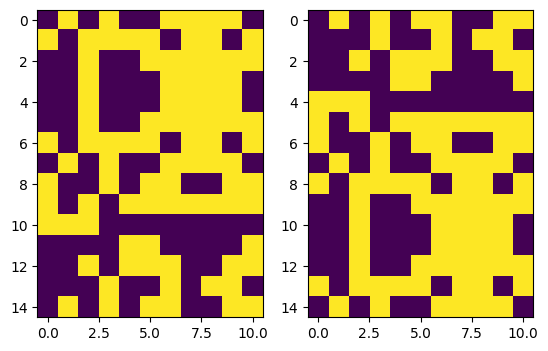

In [36]:
# visualize some
i = 10# 2 has vertical symmetry, 7 horizontal
plt.subplot(1,2,1)
plt.imshow(blocks[i]);
plt.subplot(1,2,2)
plt.imshow(np.flip(blocks[i], axis = 0)); # axis 1 is horizontal flip, 0 is vertical

In [76]:
print([block.shape for block in blocks]) #how odd, the shapes are always odd

[(13, 9), (13, 13), (9, 17), (15, 13), (7, 9), (15, 9), (15, 11), (15, 15), (13, 15), (9, 15), (15, 11), (15, 17), (11, 15), (17, 13), (15, 13), (15, 7), (17, 11), (17, 11), (13, 17), (17, 11), (11, 11), (13, 11), (11, 13), (17, 17), (9, 13), (15, 7), (13, 17), (11, 15), (7, 17), (11, 9), (7, 7), (13, 17), (17, 7), (11, 11), (13, 13), (11, 13), (15, 9), (11, 15), (9, 11), (15, 13), (9, 7), (13, 7), (13, 9), (9, 9), (9, 13), (13, 7), (17, 17), (13, 17), (7, 15), (7, 15), (15, 13), (15, 7), (15, 11), (13, 9), (15, 17), (13, 17), (9, 9), (15, 7), (17, 13), (15, 9), (13, 11), (9, 11), (11, 13), (17, 11), (7, 15), (17, 17), (17, 11), (9, 17), (9, 15), (17, 13), (17, 11), (11, 17), (15, 11), (9, 17), (11, 17), (7, 11), (7, 17), (7, 7), (17, 17), (17, 17), (17, 15), (9, 17), (7, 9), (7, 11), (7, 15), (17, 13), (17, 11), (17, 17), (15, 15), (11, 7), (11, 17), (11, 11), (11, 7), (9, 13), (13, 9), (11, 13), (11, 9), (7, 13), (15, 13), (15, 13)]


In [7]:

def split_block(block):
    """
    Input is 1 block. Block is np.array of 1 and 0 converted from # and .
    It splits the array on each row into two equal parts and remainder
    , mirrors one of the parts and asserts if they are reflecitons.
    """
    pass

answer = 0

# how many per block? # actually 1 per block interestingly
for i in range(len(blocks)):
    # first go from top to the middle
    nrow = blocks[i].shape[0]
    ncol = blocks[i].shape[1]
    # we go by rows first and then by cols
    # start with 1 since no need for 0-size arrays
    for j in range(1, nrow):
        # if we are in the first half slice like this:
        if j < nrow/2:
            # arrays are part1, part2 and remainder
            p1,p2,r = np.split(blocks[i], [j, j*2], axis=0)
            # check is p2 is mirror of p1
            # if it is true, the number of lines above it is exactly j and we need j*100
            if np.array_equal(p1, np.flip(p2, axis = 0)):
                answer += j*100 # 1 to count Trues
        else:
            # now remainder is on top and we compare bottom halves
            r,p1,p2 = np.split(blocks[i], [j-(nrow-j), j ], axis=0)
            if np.array_equal(p1, np.flip(p2, axis = 0)):
                answer += j*100
    # now go by cols
    for j in range(1, ncol):
        if j < ncol/2:
            # arrays are part1, part2 and remainder now left to right
            p1,p2,r = np.split(blocks[i], [j, j*2], axis=1)
            # we nee dnum cols to the left which is again just j (they did it on purpose I guess)
            if np.array_equal(p1, np.flip(p2, axis = 1)):
                answer += j
        else:
            # now remainder is on left and we compare right halves
            r,p1,p2 = np.split(blocks[i], [j-(ncol-j), j ], axis=1)
            if np.array_equal(p1, np.flip(p2, axis = 1)):
                answer += j

print(answer)

32035


In [ ]:
# first slide a divider line along the array (e.g. top to bottom for axis 0) till half length (2 equal arrays)
# ! handle constraint - what if we have odd number of rows?
# assert equal array after np.flip the lesser half to find mirrors
#
# then repeat along the other axis

#def read_data(file):

#def find_mirror(block):


In [51]:
# maybe try string methods first
#def horizontal_mirror:
    # find two of the same string
    # run in two oposing directions
    # return length